<a href="https://colab.research.google.com/github/andreamarin/senate-publications-analysis/blob/add%2Fnews-analysis/news_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!git clone https://github.com/andreamarin/senate-publications-analysis.git

Cloning into 'senate-publications-analysis'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 277 (delta 33), reused 5 (delta 5), pack-reused 204 (from 1)
Receiving objects: 100% (277/277), 2.06 MiB | 8.07 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
%cd senate-publications-analysis/nlp_classification/

/content/senate-publications-analysis/nlp_classification


In [3]:
!git checkout add/news-analysis

Branch 'add/news-analysis' set up to track remote branch 'add/news-analysis' from 'origin'.
Switched to a new branch 'add/news-analysis'


In [4]:
%mkdir config

In [5]:
%cp ../../drive/MyDrive/tesis/code/config/* ./config/.

In [6]:
%ls config

bot-cert.pem


In [7]:
!git pull

Already up to date.


In [8]:
!pip install -r colab_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: s

In [1]:
! pip freeze | grep spacy

en_core_web_sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl#sha256=1932429db727d4bff3deed6b34cfc05df17794f4a52eeb26cf8928f7c1a0fb85
spacy==3.8.7
spacy-legacy==3.0.12
spacy-loggers==1.0.5


In [2]:
! python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!curl ipecho.net/plain

34.80.44.117

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Imports

In [5]:
import sys
sys.path.append('/content/senate-publications-analysis/nlp_classification')

In [6]:
import os
import re
import nltk
import spacy
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from functools import partial
from itertools import chain
from wordcloud import WordCloud
from operator import itemgetter

In [12]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

In [13]:
import utils.db as db
import utils.lda_model_builder as lda
import utils.nlp_processor as nlp

In [ ]:
# importlib.reload(lda)
importlib.reload(nlp)

<module 'utils.nlp_processor' from '/content/senate-publications-analysis/nlp_classification/utils/nlp_processor.py'>

# Common functions

In [39]:
def update_processed_text(text_cols: list, data_df: pd.DataFrame, db, conn):
  # create dict column
  data_df["processed_text"] = data_df.apply(
      lambda row: {col: row[col] for col in text_cols}, axis=1
  )

  # keep only the needed columns
  update_data_df = data_df[["_id", "processed_text"]]

  # add updated timestamp
  update_data_df["updated"] = datetime.now()

  db.batch_update_records(
      update_data_df.to_dict(orient="records"),
      "articles",
      conn,
      dict_columns=["processed_text"]
  )

In [46]:

def update_topics_data(data_df: pd.DataFrame, topics_column: str, db, conn):
  # add updated timestamp
  data_df["updated"] = datetime.now()

  db.batch_update_records(
      data_df.to_dict(orient="records"),
      "articles",
      conn,
      array_columns={
          topics_column: "topic"
      }
  )

# Load data

In [14]:
conn = db.connect_mongo_db("news-data")

In [15]:
conn.list_collection_names()

['articles']

In [16]:
articles_cursor = conn.articles.find(
    projection=["newspaper", "curated_section", "date", "text", "summary", "processed_text", "updated", "url"]
  )
raw_articles_df = pd.DataFrame(articles_cursor)
raw_articles_df.head()

,_id,newspaper,date,url,summary,text,processed_text,updated,curated_section
0,330980da03e75b9dabfb2970032a60d3,Proceso,2018-01-30T00:00:00,https://www.proceso.com.mx/economia/2018/1/30/...,,CIUDAD DE MÉXICO (apro).- La Comisión Federal ...,{'normalized': 'comisión federal competencia e...,2025-09-11 05:05:49.386,economia
1,bc9c780c3d54918b0d52abd584424a8d,Proceso,2018-01-29T00:00:00,https://www.proceso.com.mx/economia/2018/1/29/...,,CIUDAD DE MÉXICO (apro).- La sexta ronda de re...,{'normalized': 'sexto ronda renegociación trat...,2025-09-11 05:05:49.386,economia
2,84bbad08a55de5c9cbf539ee0bbde843,Proceso,2018-01-17T00:00:00,https://www.proceso.com.mx/economia/2018/1/17/...,,CIUDAD DE MÉXICO (apro).- La francesa Total ab...,{'normalized': 'francés total abrir miércoles ...,2025-09-11 05:05:49.386,economia
3,f1601a6e0676a3674d29336ed568a7b0,Proceso,2018-01-27T00:00:00,https://www.proceso.com.mx/opinion/2018/1/27/d...,,CIUDAD DE MÉXICO (Proceso).- En medio de numer...,{'normalized': 'medio numeroso opinión futuro ...,2025-09-11 05:05:49.386,opinion
4,24088e2b3760b624095941830fd2667e,Proceso,2018-01-24T00:00:00,https://www.proceso.com.mx/economia/2018/1/24/...,,CIUDAD DE MÉXICO (apro).--La inflación inició ...,{'normalized': 'inflación iniciar baja embargo...,2025-09-11 05:05:49.386,economia


In [17]:
raw_articles_df.isna().sum()

,0
_id,0
newspaper,0
date,0
url,0
summary,0
text,0
processed_text,0
updated,0
curated_section,0


In [18]:
articles_df = raw_articles_df.join(
    pd.json_normalize(raw_articles_df.processed_text)
).drop(
    columns="processed_text"
)
articles_df.head(3)

,_id,newspaper,date,url,summary,text,updated,curated_section,normalized
0,330980da03e75b9dabfb2970032a60d3,Proceso,2018-01-30T00:00:00,https://www.proceso.com.mx/economia/2018/1/30/...,,CIUDAD DE MÉXICO (apro).- La Comisión Federal ...,2025-09-11 05:05:49.386,economia,comisión federal competencia económica cofece ...
1,bc9c780c3d54918b0d52abd584424a8d,Proceso,2018-01-29T00:00:00,https://www.proceso.com.mx/economia/2018/1/29/...,,CIUDAD DE MÉXICO (apro).- La sexta ronda de re...,2025-09-11 05:05:49.386,economia,sexto ronda renegociación tratado libre comerc...
2,84bbad08a55de5c9cbf539ee0bbde843,Proceso,2018-01-17T00:00:00,https://www.proceso.com.mx/economia/2018/1/17/...,,CIUDAD DE MÉXICO (apro).- La francesa Total ab...,2025-09-11 05:05:49.386,economia,francés total abrir miércoles gasolinera méxic...


In [19]:
articles_df.isna().sum()

,0
_id,0
newspaper,0
date,0
url,0
summary,0
text,0
updated,0
curated_section,0
normalized,0


## Curated sections

In [ ]:
articles_df["curated_section"] = articles_df["section"]
articles_df.head(2)

,_id,newspaper,section,date,url,summary,text,updated,normalized,url_section,curated_section
0,f5adb7c677dbd2f60d270bb33dc58fd5,Proceso,economia,2018-01-30T00:00:00,https://www.proceso.com.mx/economia/2018/1/30/...,,CIUDAD DE MÉXICO (apro).- El secretario de Hac...,2025-08-06 06:01:57.043,ciudad méxico apro secretario hacienda crédit...,NaN,economia
1,330980da03e75b9dabfb2970032a60d3,Proceso,economia,2018-01-30T00:00:00,https://www.proceso.com.mx/economia/2018/1/30/...,,CIUDAD DE MÉXICO (apro).- La Comisión Federal ...,2025-08-06 06:01:57.043,ciudad méxico apro comisión federal competenc...,NaN,economia


In [ ]:
# fix section for el financiero

# ---------------------
#  opinion section
# ---------------------
articles_df.loc[
    (articles_df.newspaper == "el financiero")
    & (articles_df.url.str.startswith("https://www.elfinanciero.com.mx/opinion/")),
    "curated_section"
] = "opinion"

# ---------------------
#  elecciones section
# ---------------------
articles_df.loc[
    (articles_df.section.str.contains("elecciones")),
    "curated_section"
] = "elecciones"



In [ ]:
# get section from url
articles_df.loc[articles_df.newspaper == "el financiero", "url_section"] = articles_df.loc[articles_df.newspaper == "el financiero"]["url"].apply(
    lambda u: (re.search(r"^https:\/\/www\.elfinanciero\.com\.mx\/([\w_-]+)\/", u).group(1)).replace("-", " ")
)

In [ ]:
articles_df.loc[
    (~articles_df.url_section.isna())
    & (articles_df.curated_section != articles_df.url_section)
  ].groupby(["curated_section", "url_section"]).count()

_id  newspaper  section  date  url  \
curated_section        url_section                                       
algarabia              mundo          1          1        1     1    1   
bajio                  economia       1          1        1     1    1   
bloomberg              nacional       1          1        1     1    1   
                       tech           1          1        1     1    1   
bloomberg businessweek empresas       1          1        1     1    1   
...                                 ...        ...      ...   ...  ...   
tech                   reflector      1          1        1     1    1   
                       salud          1          1        1     1    1   
transporte y movilidad autos          3          3        3     3    3   
                       viajes         3          3        3     3    3   
viajes                 empresas       1          1        1     1    1   

                                    summary  text  updated  normalized  
curated_section        url_section                                      
algarabia              mundo              1     1        1           1  
bajio                  economia           1     1        1           1  
bloomberg              nacional           1     1        1           1  
                       tech               1     1        1           1  
bloomberg businessweek empresas           1     1        1           1  
...                                     ...   ...      ...         ...  
tech                   reflector          1     1        1           1  
                       salud              1     1        1           1  
transporte y movilidad autos              3     3        3           3  
                       viajes             3     3        3           3  
viajes                 empresas           1     1        1           1  

[124 rows x 9 columns]

In [ ]:
skip_sections = [
    "economia",
    "ciencia",
    "culturas",
    "elecciones",
    "estados",
    "empresas",
    "estilo",
    "mercados",
    "mundo",
    "nacional",
    "opinion",
    "salud",
    "tech",
    "transporte y movilidad"
]

# update section value
articles_df.loc[
    (~articles_df.url_section.isna())
    & (articles_df.curated_section != articles_df.url_section)
    & (~articles_df.curated_section.isin(skip_sections)),
    "curated_section"
] = articles_df.loc[
    (~articles_df.url_section.isna())
    & (articles_df.curated_section != articles_df.url_section)
    & (~articles_df.curated_section.isin(skip_sections))
].url_section

In [ ]:
map_sections = {
    "tokio 2020": "deporte",
    "sonora": "estados",
    "centro": "estados",
    "monterrey": "estados",
    "guerrero": "estados",
    "puebla": "estados",
    "jalisco": "estados",
    "peninsula": "estados",
    "bajio": "estados",
    "cdmx": "estados",
    "sinaloa": "estados",
    "edomex": "estados",
    "encuestas ef": "encuestas",
    "arte e ideas": "cultura",
    "food and drink": "cultura",
    "buena vida": "cultura",
    "norte": "estados",
    "mundo empresa": "empresas",
    "mis finanzas": "finanzas personales",
    "reflector": "espectaculos",
    "tech": "tecnologia",
    "culturas": "cultura",
    "pyme": "empresas",
    "empresas ESG": "empresas",
    "deporte": "deportes",
    "ciencias": "ciencia"

}
articles_df['curated_section'] = articles_df.curated_section.replace(map_sections)

In [ ]:
articles_df.loc[
    (articles_df.section == "transporte y movilidad")
    & (articles_df.new_section == "viajes")
].url.tolist()

['https://www.elfinanciero.com.mx/viajes/finanzas-para-las-nuevas-generaciones/',
 'https://www.elfinanciero.com.mx/viajes/2022/10/05/mobility-ado-reafirma-su-compromiso-como-lider-global-en-movilidad-terrestre/',
 'https://www.elfinanciero.com.mx/viajes/2023/01/17/concreto-sostenible-facilitara-conexion-carretera-fronteriza-mexico-estados-unidos/']

In [ ]:
# update sections in db
db.batch_update_records(
    articles_df[["_id", "curated_section"]].to_dict(orient="records"),
    "articles",
    conn
)

In [ ]:
articles_df = articles_df.drop(columns=["url_section"])

## Set filtered sections

In [20]:
section_counts = articles_df.groupby("curated_section").agg({"_id": "count"}).reset_index(drop=False).rename(columns={"_id": "num_articles"})

In [21]:
section_counts.sort_values(by="num_articles", ascending=True)

,curated_section,num_articles
0,after office,1
48,transicion,1
39,retrato hablado,1
38,rankings,1
27,inmobiliario,1
17,emprendedores,1
45,suplementos,3
30,letras libres,7
31,management,8
51,viajes,9


In [22]:
remove_sections = [
    "espectaculos",
    "tendencias",
    "estilo",
    "entretenimiento",
    "autos",
    "food and drink",
    "encuestas",
    "algarabia",
    "retrato hablado",
    "signos y senales",
    "rankings",
    "finanzas personales",
    "after office",
    "transicion",
    "rankings",
    "inmobiliario",
    "emprendedores",
    "management",
    "viajes",
    "el preguntario",
    "el empresario",
    "editorial",
    "hablemos de",
    "empresas",
    "millonarios"
]

In [23]:
# TOTAL: 481 398
# NEW:   447 072
articles_df.loc[~articles_df.curated_section.isin(remove_sections)].shape

(447072, 9)

In [24]:
filtered_df = articles_df.loc[~articles_df.curated_section.isin(remove_sections)]
filtered_df.head(3)

,_id,newspaper,date,url,summary,text,updated,curated_section,normalized
0,330980da03e75b9dabfb2970032a60d3,Proceso,2018-01-30T00:00:00,https://www.proceso.com.mx/economia/2018/1/30/...,,CIUDAD DE MÉXICO (apro).- La Comisión Federal ...,2025-09-11 05:05:49.386,economia,comisión federal competencia económica cofece ...
1,bc9c780c3d54918b0d52abd584424a8d,Proceso,2018-01-29T00:00:00,https://www.proceso.com.mx/economia/2018/1/29/...,,CIUDAD DE MÉXICO (apro).- La sexta ronda de re...,2025-09-11 05:05:49.386,economia,sexto ronda renegociación tratado libre comerc...
2,84bbad08a55de5c9cbf539ee0bbde843,Proceso,2018-01-17T00:00:00,https://www.proceso.com.mx/economia/2018/1/17/...,,CIUDAD DE MÉXICO (apro).- La francesa Total ab...,2025-09-11 05:05:49.386,economia,francés total abrir miércoles gasolinera méxic...


# Analyze text length

In [ ]:
raw_articles_df["summary"] = raw_articles_df.summary.apply(str.strip)

In [ ]:
raw_articles_df["summary_word_length"] = raw_articles_df.summary.apply(
    lambda s: len(s.split())
)
raw_articles_df["text_word_length"] = raw_articles_df.text.apply(
    lambda s: len(s.split())
)

In [ ]:
# 245 192
# 481 398
empty_summary = raw_articles_df.summary_word_length <= 20
sum(empty_summary)

342383

In [ ]:
round((sum(empty_summary)/raw_articles_df.shape[0])*100, 2)

71.12

array([[<Axes: title={'center': 'summary_word_length'}>]], dtype=object)

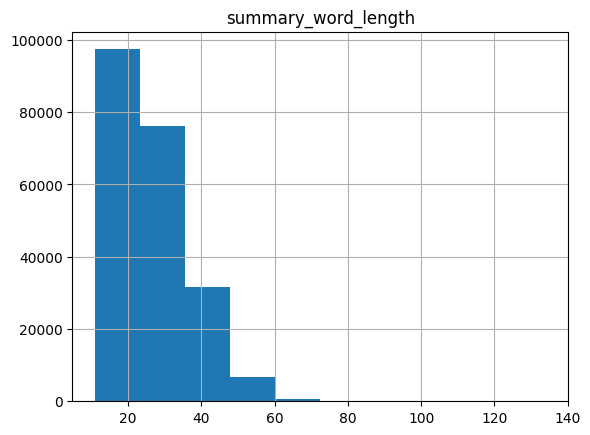

In [ ]:
raw_articles_df.loc[raw_articles_df.summary_word_length > 10].hist(column="summary_word_length")

In [ ]:
short_summaries = raw_articles_df.loc[
    (raw_articles_df.summary_word_length > 0)
    & (raw_articles_df.summary_word_length <= 10)
].sort_values(by="summary_word_length", ascending=False)

for summary in short_summaries.summary.iloc[:20]:
  print(summary)
  print("----"*10)

Fallece un paciente en SLP; 67 contagiados en 20 estados
----------------------------------------
Lozoya: si caigo, caen todos // Pandilleros tras un amparo
----------------------------------------
La ensayista lo considera un <q>gran autor y eficaz activista</q>
----------------------------------------
Ganaderos callados pero alucinados // Las mafias y sus cómplices
----------------------------------------
No se abandonará  a los trabajadores atrapados, afirma Laura Velázquez
----------------------------------------
Para entonces deberán estar concluidos los ceses de plazas duplicadas
----------------------------------------
La <q>mafia del poder</q> del rock y sus festivales desgastantes
----------------------------------------
La ministra de Seguridad acusa a los convocantes de <q>extorsión</q>
----------------------------------------
El sistema de listas acentuaría la sub  y sobrerrepresentación, aseguran
----------------------------------------
<q>Nada cambia; el caso está cerrado

array([[<Axes: title={'center': 'text_word_length'}>]], dtype=object)

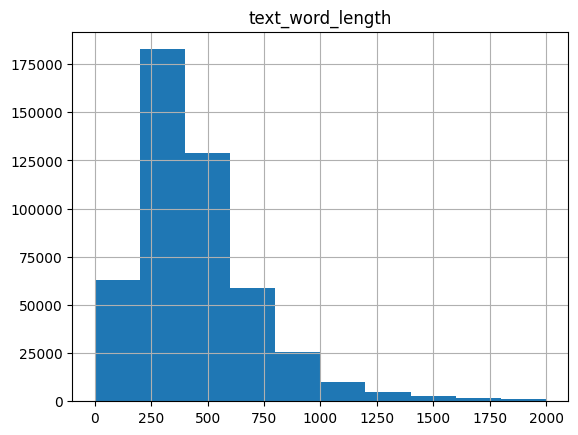

In [ ]:
raw_articles_df.loc[raw_articles_df.text_word_length < 2000].hist(column="text_word_length")

# Word frequencies

In [ ]:
# get word frequencies
from nltk import word_tokenize
from nltk.probability import FreqDist

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
long_string = " ".join(list(articles_df.normalized))

In [ ]:
#tokenize text by words
words = word_tokenize(long_string)

#check the number of words 117 237 140
print(f"The total number of words in the text is {len(words)}")

The total number of words in the text is 110422888


In [ ]:
fdist = FreqDist(words)

In [ ]:
fdist.most_common(10)

[('poder', 655844),
 ('año', 577379),
 ('méxico', 565870),
 ('gobierno', 384297),
 ('país', 371263),
 ('persona', 356940),
 ('nacional', 352631),
 ('nuevo', 274013),
 ('presidente', 272988),
 ('caso', 255752)]

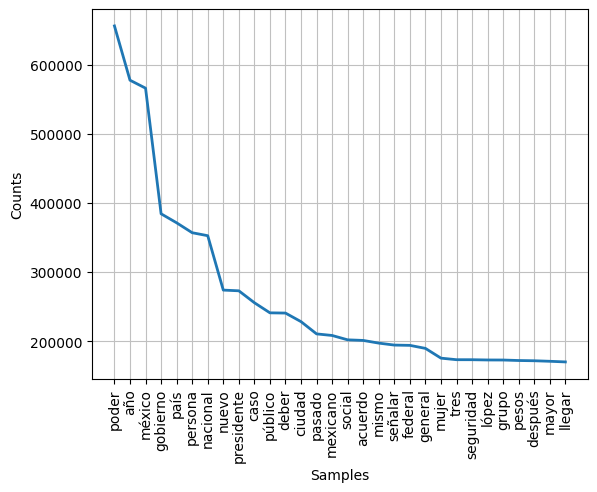

In [ ]:
fdist.plot(30)
plt.show()

In [ ]:
word_distribution = pd.DataFrame(fdist.items(), columns=["word", "frequency"])
word_distribution.head(2)

,word,frequency
0,secretario,66010
1,hacienda,25525


In [ ]:
quantiles = {
    0.5: "lte",
    0.99: "gte"
}
for quantile, comparison in quantiles.items():
  percentile_value = word_distribution['frequency'].quantile(quantile)

  if comparison == "lte":
    num_words = word_distribution.loc[word_distribution.frequency <= percentile_value].shape[0]
  elif comparison == "gte":
    num_words = word_distribution.loc[word_distribution.frequency >= percentile_value].shape[0]
  else:
    num_words = None

  print(f"{quantile} percentile – {percentile_value} with {num_words:,} words")

0.5 percentile – 1.0 with 469,337 words
0.99 percentile – 1355.0 with 8,145 words


In [ ]:
word_distribution.loc[word_distribution.frequency >= 75]

,word,frequency
0,ciudad,290800
1,méxico,628858
2,apro,87869
3,secretario,62953
4,hacienda,25563
...,...,...
661692,fdic,133
663298,bájmut,78
701994,lahaina,79
716730,cuacolandia,100


### Word cloud

In [ ]:
wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3,
    contour_color='steelblue',
    collocations=True
)

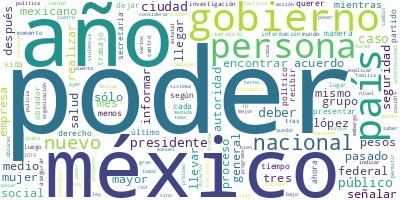

In [ ]:
wordcloud.generate_from_frequencies(dict(fdist))
wordcloud.to_image()

# Text pre-processing

In [53]:
from tqdm import tqdm
tqdm.pandas()

In [54]:
BATCH_SIZE = 10000

In [55]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [56]:
def remove_tags(text: str) -> str:
  return re.sub(r"<\/?.*?>", "", text)

In [57]:
def remove_numbers(text: str) -> str:
  return re.sub(r"\b\d+\b", " ", text)

In [58]:
def remove_news_start(text: str) -> str:
  """
  Remove the <city_name> (apro).- from the beginning of the text
  """
  return re.sub(r"^[\wáéíóúÁÉÍÓÚ\s,]+\.?-?\s?\((.*?)\)+\.?-?\s?", "", text)

In [60]:
extra_stop_words = [
    "ser", "haber", "tener", "decir", "mil", "apro", "ver", "ciento", "millón", "dar", "primero", "si", "dos",
    "parte", "día", "así", "alguno", "unidos", "además", "vez", "seguir", "hora", "segundo", "minuto",
    "san", "hacer", "ir", "dar", "semana", "año", "él", "the"
]
final_stop_words = nltk.corpus.stopwords.words("spanish") + extra_stop_words

In [61]:
remove_words = []

In [62]:
procesor = nlp.NlpProcessor(
    texts_df = articles_df,
    spacy_model_name = "es_core_news_lg",
    process_text_config = {
        "stop_words": final_stop_words,
        # "remove_words": remove_words
    },
    extra_processing_steps = [remove_tags, remove_numbers, remove_news_start],
)

In [67]:
print(filtered_df.updated.max())
last_updated = '2026-02-02 20:46:25.617658'

2025-09-11 14:30:47.050000


In [70]:
pending_articles_condition = (
    (filtered_df.updated <= last_updated)
    # & (
    #     (articles_df.normalized.str.contains(" año "))
    #     | (articles_df.newspaper == "Proceso")
    #     | (articles_df.normalized.str.contains(r"\d"))
    # )
)

pending_articles = filtered_df.loc[pending_articles_condition].reset_index(drop=True)

In [71]:
# 481 398 TOTAL
# 459 978
total_artices = pending_articles.shape[0]
total_artices

447072

In [ ]:
for start in tqdm(range(0, total_artices, BATCH_SIZE)):
  end = min(start + BATCH_SIZE, total_artices)

  batch_df = pending_articles.iloc[start:end]

  batch_df.loc[:, "normalized"] = procesor.process_corpus(batch_df.text)

  update_processed_text(["normalized"], batch_df, db, conn)

 27%|██▋       | 12/45 [1:40:47<4:31:56, 494.43s/it]

# LDA models

In [ ]:
BASE_PATH = "/content/drive/MyDrive/tesis"
FOLDER_NAME = "news_models"

TOPICS_CONFIG = {
    "min_topics": 9,
    "max_topics": 13,
    "step_size": 1
}

In [ ]:
filtered_df = articles_df.loc[~articles_df.curated_section.isin(remove_sections)]
filtered_df.head(3)

In [ ]:
lda_model = lda.LDAModelBuilder(
    texts_df = filtered_df,
    folder_name = FOLDER_NAME,
    num_topics_config = TOPICS_CONFIG,
    base_path = BASE_PATH,
    model_passes = 150
)

## Generate models

In [ ]:
lda_model.build_lda_models("normalized")

In [ ]:
lda_model

## Print results

In [ ]:
lda_model.print_topics("normalized")

Topics for: normalized_all, 6
(0, '0.009*"caso" + 0.007*"justicia" + 0.007*"persona" + 0.006*"investigación" + 0.006*"poder" + 0.005*"público" + 0.005*"él" + 0.005*"violencia" + 0.005*"derechos" + 0.005*"fiscalía"')
(1, '0.006*"dólares" + 0.006*"país" + 0.005*"él" + 0.004*"mexicano" + 0.004*"méxico" + 0.004*"poder" + 0.004*"banco" + 0.004*"mes" + 0.003*"mientras" + 0.003*"punto"')
(2, '0.010*"poder" + 0.008*"méxico" + 0.007*"país" + 0.007*"persona" + 0.006*"salud" + 0.005*"él" + 0.005*"mayor" + 0.005*"pesos" + 0.004*"deber" + 0.004*"sistema"')
(3, '0.010*"él" + 0.007*"poder" + 0.004*"vida" + 0.003*"mujer" + 0.003*"méxico" + 0.003*"historia" + 0.003*"saber" + 0.003*"querer" + 0.003*"mismo" + 0.003*"mundo"')
(4, '0.012*"presidente" + 0.010*"gobierno" + 0.009*"lópez" + 0.008*"poder" + 0.008*"méxico" + 0.008*"obrador" + 0.008*"electoral" + 0.007*"él" + 0.006*"partido" + 0.006*"nacional"')
(5, '0.007*"ciudad" + 0.007*"persona" + 0.005*"zona" + 0.005*"méxico" + 0.005*"municipio" + 0.005*"inf

In [28]:
topics_df, vis = lda_model.generate_model_vis("normalized", 9)

In [29]:
topics_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,"0.013*""presidente""","0.012*""pesos""","0.011*""agua""","0.009*""persona""","0.010*""poder""","0.011*""él""","0.012*""poder""","0.009*""equipo""","0.012*""país"""
1,"0.011*""lópez""","0.010*""méxico""","0.010*""méxico""","0.008*""seguridad""","0.009*""ley""","0.007*""poder""","0.011*""persona""","0.008*""él""","0.007*""gobierno"""
2,"0.011*""gobierno""","0.009*""empresa""","0.009*""ciudad""","0.007*""policía""","0.007*""público""","0.004*""vida""","0.009*""salud""","0.006*""partido""","0.006*""presidente"""
3,"0.010*""obrador""","0.008*""dólares""","0.007*""zona""","0.006*""fiscalía""","0.007*""caso""","0.004*""historia""","0.008*""él""","0.006*""liga""","0.005*""guerra"""
4,"0.009*""electoral""","0.007*""banco""","0.005*""nacional""","0.006*""autoridad""","0.007*""derecho""","0.004*""méxico""","0.006*""mujer""","0.005*""final""","0.005*""poder"""
5,"0.009*""méxico""","0.007*""mercado""","0.004*""gobierno""","0.005*""investigación""","0.007*""federal""","0.004*""libro""","0.005*""país""","0.005*""mexicano""","0.005*""él"""
6,"0.008*""partido""","0.006*""precio""","0.004*""tren""","0.005*""violencia""","0.006*""proceso""","0.003*""obra""","0.005*""caso""","0.005*""tras""","0.005*""israel"""
7,"0.008*""morena""","0.006*""tasa""","0.004*""informar""","0.005*""mujer""","0.006*""justicia""","0.003*""mismo""","0.005*""méxico""","0.005*""ganar""","0.005*""migrant"""
8,"0.008*""él""","0.006*""económico""","0.004*""nuevo""","0.005*""víctima""","0.006*""él""","0.003*""saber""","0.005*""social""","0.004*""después""","0.004*""internacional"""
9,"0.008*""poder""","0.006*""mayor""","0.004*""servicio""","0.004*""él""","0.006*""deber""","0.003*""querer""","0.005*""deber""","0.004*""mundial""","0.004*""ucrania"""


In [30]:
import pyLDAvis

In [31]:
pyLDAvis.display(vis)

## Topics per document

In [48]:
text_type = "normalized"
num_topics = 12

In [49]:
lda_model.set_model(text_type, num_topics)

In [50]:
topics_column = f"topics_{text_type}_{num_topics}_model"
filtered_df[topics_column] = filtered_df["normalized"].apply(lda_model.get_publication_topics)

In [51]:
topics_df = filtered_df[["_id", topics_column]]
topics_df.head()

,_id,topics_normalized_12_model
0,330980da03e75b9dabfb2970032a60d3,"[{'topic': 0, 'score': 0.1132514700293541}, {'..."
1,bc9c780c3d54918b0d52abd584424a8d,"[{'topic': 0, 'score': 0.0697949230670929}, {'..."
2,84bbad08a55de5c9cbf539ee0bbde843,"[{'topic': 1, 'score': 0.5137761831283569}, {'..."
3,f1601a6e0676a3674d29336ed568a7b0,"[{'topic': 0, 'score': 0.14529015123844147}, {..."
4,24088e2b3760b624095941830fd2667e,"[{'topic': 1, 'score': 0.95438152551651}, {'to..."


In [52]:
update_topics_data(topics_df, topics_column, db, conn)

In [66]:
topics_df

,_id,topics_normalized_12_model,updated
0,330980da03e75b9dabfb2970032a60d3,"[{'topic': 0, 'score': 0.1132514700293541}, {'...",2026-02-02 20:46:25.617658
1,bc9c780c3d54918b0d52abd584424a8d,"[{'topic': 0, 'score': 0.0697949230670929}, {'...",2026-02-02 20:46:25.617658
2,84bbad08a55de5c9cbf539ee0bbde843,"[{'topic': 1, 'score': 0.5137761831283569}, {'...",2026-02-02 20:46:25.617658
3,f1601a6e0676a3674d29336ed568a7b0,"[{'topic': 0, 'score': 0.14529015123844147}, {...",2026-02-02 20:46:25.617658
4,24088e2b3760b624095941830fd2667e,"[{'topic': 1, 'score': 0.95438152551651}, {'to...",2026-02-02 20:46:25.617658
...,...,...,...
481392,53246f32efe4f3991b437e012be2fb1d,"[{'topic': 0, 'score': 0.045732658356428146}, ...",2026-02-02 20:46:25.617658
481393,d3faedd23880c63d4b846080c5b46e28,"[{'topic': 0, 'score': 0.030783409252762794}, ...",2026-02-02 20:46:25.617658
481394,4acb398f32fdd5de31974466f7f729c2,"[{'topic': 0, 'score': 0.05652879178524017}, {...",2026-02-02 20:46:25.617658
481395,f902ffaa4299684cfb4d729264e02d52,"[{'topic': 2, 'score': 0.35454392433166504}, {...",2026-02-02 20:46:25.617658
